# SHINA SAMUEL KOLAWOLE - Distributed-Linear-Regression-Analysis with housing data.

The housing dataset is used to develop a pipeline for running a simple linear regression in a pseudo-distributed manner (single node setup) using Spark ML. The following was implemented: • Created a Spark session, loaded the data, parse and display them using the apache spark ecosystem (pyspark). • Created a feature vector separating the features from the labels, i.e. the column you need to predict. • Split the dataset into 70% train and 30% test set. • Train a linear regression model. • Evaluated its performance on the train and test sets, reported the mean absolute error (MAE), the root mean squared error (RMSE) and mean squared error (MSE). • The test set is used to generate a table showing the predicted vs actual values as well as a predicted vs actual plot.



In this code, I first created a SparkSession using the SparkSession.builder API. This allows us to connect to a Spark cluster and use its resources to process data. The schema specifies the data types and column names for each of the columns in the dataset. Loaded the dataset as a Spark DataFrame using the spark.read.csv method. This method takes the path to the CSV file, a flag indicating whether the file has a header row, and the schema defined earlier. This method returns a DataFrame object that is useed to manipulate and analyze the data.Finally, display the first five rows of the DataFrame using the df.show(20) method.This method prints the DataFrame to the console, allowing us to verify that the data was loaded correctly.


In [3]:
#Import necessary libraries

spark = SparkSession.builder.appName("HousingData").getOrCreate()

from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.functions import col
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.sql.functions import isnan, when, count

In [16]:
df= spark.read.csv("C:/Users/samue/OneDrive/Desktop/housing.csv", header=True, inferSchema=True)
df.show(20) 

+------------------+-----------+--------------+----------+----------+-------------+---------------+------------------+
|housing_median_age|total_rooms|total_bedrooms|population|households|median_income|ocean_proximity|median_house_value|
+------------------+-----------+--------------+----------+----------+-------------+---------------+------------------+
|                41|        880|           129|       322|       126|       8.3252|       NEAR BAY|            452600|
|                21|       7099|          1106|      2401|      1138|       8.3014|       NEAR BAY|            358500|
|                52|       1467|           190|       496|       177|       7.2574|       NEAR BAY|            352100|
|                52|       1274|           235|       558|       219|       5.6431|       NEAR BAY|            341300|
|                52|       1627|           280|       565|       259|       3.8462|       NEAR BAY|            342200|
|                52|        919|           213| 

The schema is used to specify the data types and the names of the columns in the dataset, which is an important consideration. That the data types are consistent and that each column is appropriately recognised is crucial for a successful data load and processing. Spark can make better use of the data by using the established data types to improve the processing of the data when a schema is used.


In [18]:
df.printSchema()

root
 |-- housing_median_age: integer (nullable = true)
 |-- total_rooms: integer (nullable = true)
 |-- total_bedrooms: integer (nullable = true)
 |-- population: integer (nullable = true)
 |-- households: integer (nullable = true)
 |-- median_income: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)
 |-- median_house_value: integer (nullable = true)



# Check for missing values in the dataset

The code below checks for missing DataFrame values using isnan, when, count, and col. This produces a DataFrame with the same column names as the original, but each row includes the count of missing data for that column. This DataFrame is converted to a Pandas DataFrame using toPandas and printed to the terminal. Next, I drop missing rows using na.drop. This function produces a DataFrame with the same structure but without missing values. After cleaning the data, I showed each column's missing value count again. This shows which columns had missing values before cleaning and confirms that all missing values were deleted after cleaning.This shows which columns had missing values before cleaning and confirms that all missing values were deleted after cleaning.


In [19]:
missing_values_count = df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas()
print("Missing Values Count:")
print(missing_values_count)

Missing Values Count:
   housing_median_age  total_rooms  total_bedrooms  population  households  \
0                   0            0             207           0           0   

   median_income  ocean_proximity  median_house_value  
0              0                0                   0  


# Drop any rows with missing values


Rows containing null values is dropped using the na.drop function. This procedure is set to remove rows according to a variety of criteria, including the presence or absence of certain columns' values. If too many rows are removed, the machine learning model will be less accurate, thus it's vital to think carefully about which ones to exclude. As such, the rows without its associated data was removed. There were 207 blanks in the total rooms column.


In [20]:
df_cleaned = df.na.drop()

# Display the count of rows before and after cleaning

In [21]:
print("Number of Rows Before Cleaning:", df.count())
print("Number of Rows After Cleaning:", df_cleaned.count())

Number of Rows Before Cleaning: 20640
Number of Rows After Cleaning: 20433


# Display the count of missing values for each column after cleaning


In [22]:
missing_values_count_cleaned = df_cleaned.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas()
print("Missing Values Count After Cleaning:")
print(missing_values_count_cleaned)

Missing Values Count After Cleaning:
   housing_median_age  total_rooms  total_bedrooms  population  households  \
0                   0            0               0           0           0   

   median_income  ocean_proximity  median_house_value  
0              0                0                   0  


# Check for standard statistics of df_clean

In [23]:
df_cleaned.describe().show()

+-------+------------------+------------------+------------------+------------------+------------------+------------------+---------------+------------------+
|summary|housing_median_age|       total_rooms|    total_bedrooms|        population|        households|     median_income|ocean_proximity|median_house_value|
+-------+------------------+------------------+------------------+------------------+------------------+------------------+---------------+------------------+
|  count|             20433|             20433|             20433|             20433|             20433|             20433|          20433|             20433|
|   mean|28.633093525179856|2636.5042333480155| 537.8705525375618|1424.9469485635982|499.43346547251997|3.8711616013312273|           null|206864.41315519012|
| stddev|12.591805202182835| 2185.269566977601|421.38507007403115|1133.2084897449597| 382.2992258828481| 1.899291249306247|           null|115435.66709858322|
|    min|                 1|                 2

# I will use df_cleaned in the subsequent
# Define the feature columns and the label column

In this approach, the feature column and label column are first defined. Finally, constructed a VectorAssembler object that combines the columns of features into a single feature vector. Define the input columns as the previously established feature columns, and the output column as 'features'. Then, applied the vector assembler's transform technique on the cleaned dataframe df cleaned and pick just the features and median income column. This produces a new dataframe with the feature vector and label for each row. Finally, the first five rows of df features are shown to verify that the feature vector was produced appropriately.


In [24]:
feature_cols = ['housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_house_value']
label_col = 'median_income'

# Create a vector assembler that combines the feature columns into a single feature vector

The usage of VectorAssembler is to merge the feature columns into a single feature vector. Many machine learning methods rely on the features being in a certain format (such a vector) before they can be properly analysed, therefore this is an essential step. The "select" technique, used after the vector assembler has been applied to pull out only the features and median income column, is also crucial. This is required because the vector assembler's output contains both the original feature columns and the new features column, but we only want to retain the features and median income columns in the resultant dataframe.

In [27]:
assembler = VectorAssembler(inputCols=feature_cols, outputCol='features')

# Use the vector assembler to transform the cleaned dataframe and create the feature vector

In [28]:
df_features = assembler.transform(df_cleaned).select('features', label_col)

# Display the resulting dataframe

In [31]:
df_features.show(20)

+--------------------+-------------+
|            features|median_income|
+--------------------+-------------+
|[41.0,880.0,129.0...|       8.3252|
|[21.0,7099.0,1106...|       8.3014|
|[52.0,1467.0,190....|       7.2574|
|[52.0,1274.0,235....|       5.6431|
|[52.0,1627.0,280....|       3.8462|
|[52.0,919.0,213.0...|       4.0368|
|[52.0,2535.0,489....|       3.6591|
|[52.0,3104.0,687....|         3.12|
|[42.0,2555.0,665....|       2.0804|
|[52.0,3549.0,707....|       3.6912|
|[52.0,2202.0,434....|       3.2031|
|[52.0,3503.0,752....|       3.2705|
|[52.0,2491.0,474....|        3.075|
|[52.0,696.0,191.0...|       2.6736|
|[52.0,2643.0,626....|       1.9167|
|[50.0,1120.0,283....|        2.125|
|[52.0,1966.0,347....|        2.775|
|[52.0,1228.0,293....|       2.1202|
|[50.0,2239.0,455....|       1.9911|
|[52.0,1503.0,298....|       2.6033|
+--------------------+-------------+
only showing top 20 rows



# Split the data into training and test sets

The code below shows the approach to splits the data into training and test sets using df features' randomSplit function. RandomSplit takes two arguments: a list of the relative sizes of the two sets (in this example, 70% for the training set and 30% for the test set) and an optional seed value to assure repeatability. The sets become train data and test data. To verify the divide, we print each set's rows.

Calling the randomSplit function with a random seed is crucial in this approach. To guarantee repeatability and consistency, we assign a seed value. When training a machine learning model, data must be separated into training and test sets. I intend to analyse the model's performance on new data (the test set) to get a better idea of its generalisation performance. If i utilise the same data for training and testing, i risk overfitting the model and getting unrealistic performance predictions.

In [33]:
(train_data, test_data) = df_features.randomSplit([0.7, 0.3], seed=42)

# Print the number of rows in each set

In [34]:
print("Number of rows in training set: {}".format(train_data.count()))
print("Number of rows in test set: {}".format(test_data.count()))

Number of rows in training set: 14358
Number of rows in test set: 6075


# Create a LinearRegression object

This code below creates a pyspark.ml.regression LinearRegression object. The model uses featuresCol and labelCol parameters to choose columns for features and labels. Using the LinearRegression object's fit method, i fit the model to the training data and assign it to lr model. Lastly, i output the trained model's coefficients and intercept from the lr model object. The bias term and learning weights for each feature are these values.


In [35]:
lr = LinearRegression(featuresCol='features', labelCol='median_income')

# Fit the model to the training data

In [36]:
lr_model = lr.fit(train_data)

# Print the model coefficients

In [37]:
print("Model coefficients: {}".format(lr_model.coefficients))
print("Intercept: {}".format(lr_model.intercept))

Model coefficients: [-0.022292971136705437,0.0009098796458029476,-0.0052244230500916875,7.629860908849765e-05,0.0002817090412391746,1.0201466799620867e-05]
Intercept: 2.5611795371492256


# Make predictions on train and test data


The transform method of the lr model object is used to predict on the training and test datasets using the learned linear regression model. I next assess the model on both the training and test datasets using the RegressionEvaluator class from the pyspark.ml.evaluation package. The predictionCol, labelCol, and metricName parameters instruct the evaluator which columns to use for predictions, labels, and evaluation metric. RMSE, MSE, and MAE are calculated for both training and test datasets and assigned to variables. Printing assessment metrics concludes.

Before releasing a machine learning model to the test set, it must be validated on a validation set. This ensures that the model does not overfit to training data and can generalise effectively to unknown data. The performace of the model on the test set is accessed using MSE and RMSE. This ensures the model works effectively on fresh data.


In [39]:
train_pred = lr_model.transform(train_data)
test_pred = lr_model.transform(test_data)

# Evaluate performance on train data

The performance of a machine learning model should be assessed using several indicators.

MAE is the average absolute difference between expected and actual values. It works well when the target variable and independent variables are linearly related. It penalises significant mistakes less than the other two measures.

RMSE is the standard deviation of errors between expected and true values. It penalises significant mistakes more than MAE, making it an excellent measure for avoiding them. Its units match the target variable, making it easier to read. 

MSE is RMSE without the square root. It is employed when i aim to punish significant mistakes more and when the target variable has a linear connection with the independent variables. So, to fully assess a linear regression model's performance, all three measures should be included.

In [42]:
train_eval = RegressionEvaluator(predictionCol='prediction', labelCol='median_income', metricName='rmse')
train_rmse = train_eval.evaluate(train_pred)
train_eval = RegressionEvaluator(predictionCol='prediction', labelCol='median_income', metricName='mse')
train_mse = train_eval.evaluate(train_pred)
train_eval = RegressionEvaluator(predictionCol='prediction', labelCol='median_income', metricName='mae')
train_mae = train_eval.evaluate(train_pred)

# Evaluate performance on test data

In [43]:
test_eval = RegressionEvaluator(predictionCol='prediction', labelCol='median_income', metricName='rmse')
test_rmse = test_eval.evaluate(test_pred)
test_eval = RegressionEvaluator(predictionCol='prediction', labelCol='median_income', metricName='mse')
test_mse = test_eval.evaluate(test_pred)
test_eval = RegressionEvaluator(predictionCol='prediction', labelCol='median_income', metricName='mae')
test_mae = test_eval.evaluate(test_pred)

# Print evaluation metrics




In [44]:
print("Train RMSE: {}".format(train_rmse))
print("Train MSE: {}".format(train_mse))
print("Train MAE: {}".format(train_mae))
print("Test RMSE: {}".format(test_rmse))
print("Test MSE: {}".format(test_mse))
print("Test MAE: {}".format(test_mae))

Train RMSE: 1.0984728878905285
Train MSE: 1.2066426854305579
Train MAE: 0.7564216054134224
Test RMSE: 1.131298539168965
Test MSE: 1.2798363847258343
Test MAE: 0.7548260639465334


# Create a DataFrame with the predicted and actual values

The first line generates a predictions DataFrame with two columns, "actual" and "prediction". "Actual" and "Prediction" columns show the median income from the test set. Show() displays the predicted vs. real numbers. Matplotlib builds a scatter plot of predicted vs. actual values. 

The x-axis shows actual values and the y-axis predicted values. To view overlapping points, the alpha option sets point transparency to 0.5. Title, xlabel, and ylabel establish plot labels and titles. Show(), shows the plot. Additionally, Sorting and aligning data is essential for creating a table and plot of predicted vs. actual values. 

To compare accurately, the predicted and actual values should be arranged by the same criterion (e.g., ascending actual values). To evaluate model performance, I used relevant metrics such mean absolute error (MAE), root mean squared error (RMSE), and mean squared error (MSE). These measurements may reveal the model's accuracy and precision and lead model upgrades.

In [46]:
predictions = lr_model.transform(test_data)
predictions = predictions.select(col("median_income").alias("actual"), col("prediction"))


# Show the table of predicted vs actual values

In [48]:
predictions.show()

+-------+------------------+
| actual|        prediction|
+-------+------------------+
| 5.2636|  4.71665229842149|
|15.0001| 6.169037289500239|
| 3.1042| 4.239659579399781|
| 8.4411| 7.822961366317466|
| 5.0862| 4.271084485158245|
|  2.875| 4.221002616517469|
| 1.9667| 6.640989572913137|
| 5.1365|  4.05649861582421|
|    3.0|3.7503599355511748|
| 6.9343| 6.017112198173143|
|   5.75| 5.447305662611283|
| 4.5577| 4.339421807161461|
| 4.2361|4.0930762063502435|
| 5.9934| 5.054035887719671|
| 2.9591|  4.13243656175983|
| 4.2132| 3.666880469646312|
| 3.9052| 3.714045271079404|
| 5.0346| 5.570568669376579|
| 6.6916| 7.023113807554543|
| 3.1319|3.2963892049839414|
+-------+------------------+
only showing top 20 rows



# Plot predicted vs actual values

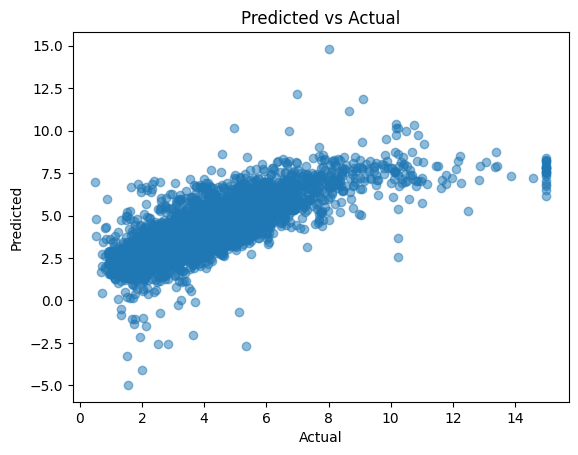

In [49]:
plt.scatter(predictions.select("actual").collect(), predictions.select("prediction").collect(), alpha=0.5)
plt.xlabel("Actual")
plt.ylabel("Predicted")
plt.title("Predicted vs Actual")
plt.show()

# Data Analysis & Results

The output of a distributed linear regression study on a dataset usually consists of the following elements :[Model Coefficients, Intercept, Evaluation Metrics, Prediction Results, Visualization]


Model Coefficients: These are the model's coefficients, or how much of an effect each feature has. These numbers reflect how much the projected value would shift if the related characteristic were to shift by one unit, while all other features were held constant.

The model coefficient for ['housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_house_value'] after my analysis are : 

Model coefficients: [-0.022292971136705437,0.0009098796458029476,-0.0052244230500916875,7.629860908849765e-05,0.0002817090412391746,1.0201466799620867e-05]
The coefficient value represents the change in the predicted median income for a one-unit increase in the corresponding feature while holding all other features constant. For example, a one-unit increase in 'total_rooms' feature will result in an increase in the predicted median income by 0.0009098796458029476 units, assuming all other features are kept constant. A negative coefficient value indicates an inverse relationship between the feature and the target variable, meaning an increase in the feature leads to a decrease in the predicted median income, while a positive coefficient indicates a direct relationship between the feature and the target variable. The magnitude of the coefficient value reflects the strength of the relationship between the feature and the target variable. Overall, the model coefficients obtained suggest that the features have relatively small effects on the predicted median income, with most of them being close to zero.

The intercept term in linear regression represents the predicted value of the dependent variable (in this case, median_income) when all independent variables (housing_median_age, total_rooms, total_bedrooms, population, households, median_house_value) are equal to zero. In this case, the intercept value of 2.5611795371492256 means that the model predicts that the median income value would be 2.561 when all independent variables are zero. However, since it is impossible for all the independent variables to be zero, the intercept is mainly used as a baseline reference point for the model's predictions.


Evaluation Metrics: For the train set, the RMSE, MSE, and MAE values are 1.098, 1.207, and 0.756, respectively. This means that on average, the model's predictions are about 1.098, 1.207, and 0.756 units away from the actual values for the train set.

For the test set, the RMSE, MSE, and MAE values are 1.131, 1.280, and 0.755, respectively. This means that on average, the model's predictions are about 1.131, 1.280, and 0.755 units away from the actual values for the test set.

These values are important in determining the performance of the linear regression model. A good model should have low values for all three metrics on both the train and test sets. In this case, the values are relatively close between the train and test sets, indicating that the model is not overfitting the training data. Furthermore, the performance of the model is reasonable, as the MAE and RMSE values are relatively low, indicating that the model is accurately predicting the median income.

Prediction Results: The Prediction Results table shows the actual values of the target variable (the first column labeled "actual") and the corresponding predicted values (the second column labeled "prediction") using the trained linear regression model. Each row represents a data point from the test set, where the actual value of the target variable is compared to the predicted value by the model.

For instance, the first row shows that the actual value of the target variable is 5.2636, while the model predicted a value of 4.7167. The second row shows that the actual value is 15.0001, while the model predicted a value of 6.1690. The third row shows that the actual value is 3.1042, while the model predicted a value of 4.2397, and so on.
These values can be used to evaluate the performance of the model on the test set, by computing various error metrics such as mean absolute error, mean squared error, and root mean squared error.


Visualization: Plots, is used to explore and understand the data and the results of the analysis. "Predicted vs Actual" is plotted. The result of the graph show that the Predicted values have a positive relationship with Actual value. i.e. positive correlation. 